In [1]:
using DataFrames, CSV, MLJ, VegaLite

In [2]:
# Import training dataset
lichen_training = CSV.read("C:/Users/julio/Downloads/lichen_training.csv", DataFrame) |>
x -> select(x, "Total.lichen", "basal_area", "PL", "mean_Long") |>
x -> rename(x, ["biomass", "basalarea", "pl", "lon"]) |>
x -> coerce(x, Count => Continuous);

In [3]:
lichen_training[!, "biomass_log"] = log.(lichen_training[!, :biomass])
select!(lichen_training, Not(:biomass));

In [4]:
schema(lichen_training)

┌─────────────┬─────────┬────────────┐
│ _.names     │ _.types │ _.scitypes │
├─────────────┼─────────┼────────────┤
│ basalarea   │ Float64 │ Continuous │
│ pl          │ Float64 │ Continuous │
│ lon         │ Float64 │ Continuous │
│ biomass_log │ Float64 │ Continuous │
└─────────────┴─────────┴────────────┘
_.nrows = 78


In [5]:
# Split predictors (X) and response variable (y)
y, X = unpack(lichen_training, ==(:biomass_log), _ -> true);

In [6]:
# Load a RandomForestRegressor
RandomForestRegressor = @load RandomForestRegressor pkg=DecisionTree

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\julio\.julia\packages\MLJModels\GKDnU\src\loading.jl:168


import MLJDecisionTreeInterface

 ✔


MLJDecisionTreeInterface.RandomForestRegressor

In [7]:
# Instantiate a random forest regressor model using a pipeline
RandomForestRegressorPipe = @pipeline(Standardizer(), RandomForestRegressor())

Pipeline259(
    standardizer = Standardizer(
            features = Symbol[],
            ignore = false,
            ordered_factor = false,
            count = false),
    random_forest_regressor = RandomForestRegressor(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 0.7,
            pdf_smoothing = 0.0,
            rng = Random._GLOBAL_RNG()))

In [8]:
# Create an MLJ machine (model + data)
RandomForestModel = machine(RandomForestRegressorPipe, X, y)

Machine{Pipeline259,…} trained 0 times; caches data
  args: 
    1:	Source @357 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @251 ⏎ `AbstractVector{Continuous}`


In [9]:
# Split into train/test datasets
train, test = partition(eachindex(y), 0.8, shuffle=true, rng=1010)

([66, 63, 5, 22, 49, 15, 47, 64, 35, 12  …  61, 57, 21, 14, 78, 40, 27, 74, 68, 18], [2, 53, 50, 39, 38, 46, 77, 29, 69, 7, 60, 59, 17, 30, 43, 51])

In [10]:
# Fit the machine
fit!(RandomForestModel, rows=train)

┌ Info: Training Machine{Pipeline259,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ In

fo: Training Machine{RandomForestRegressor,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


Machine{Pipeline259,…} trained 1 time; caches data
  args: 
    1:	Source @357 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @251 ⏎ `AbstractVector{Continuous}`


In [11]:
# Check trained parameters
fp = fitted_params(RandomForestModel)

(random_forest_regressor = (forest = Ensemble of Decision Trees
Trees:      10
Avg Leaves: 29.5
Avg Depth:  8.7,),
 standardizer = Dict(:basalarea => (19.78467741935484, 9.711812769575257), :pl => (54.33870967741935, 44.014879581083505), :lon => (-125.36747067741938, 0.8869067414269242)),
 machines = Machine[Machine{Standardizer,…}, Machine{RandomForestRegressor,…}],
 fitted_params_given_machine = OrderedCollections.LittleDict{Any, Any, Vector{Any}, Vector{Any}}(Machine{Standardizer,…} => Dict(:basalarea => (19.78467741935484, 9.711812769575257), :pl => (54.33870967741935, 44.014879581083505), :lon => (-125.36747067741938, 0.8869067414269242)), Machine{RandomForestRegressor,…} => (forest = Ensemble of Decision Trees
Trees:      10
Avg Leaves: 29.5
Avg Depth:  8.7,)),)

In [17]:
# Make predictions on test and train subsets
y_test_pred = predict(RandomForestModel, rows=test)
y_train_pred = predict(RandomForestModel, rows=train)

62-element Vector{Float64}:
 6.016877710814443
 3.1097445792067786
 2.43752654364511
 7.406584534293003
 4.856494661066178
 6.588666431210854
 2.617576843906628
 6.6340548393663195
 4.657778993757758
 4.749622373920719
 ⋮
 5.5034924566883685
 2.5341119407455657
 5.590940431003202
 5.117753995684475
 5.93708859692901
 7.712083104707693
 5.758074420784136
 3.9206836924875423
 6.221175201713558

In [18]:
rms(y_test_pred, y[test])

2.7544949013787776

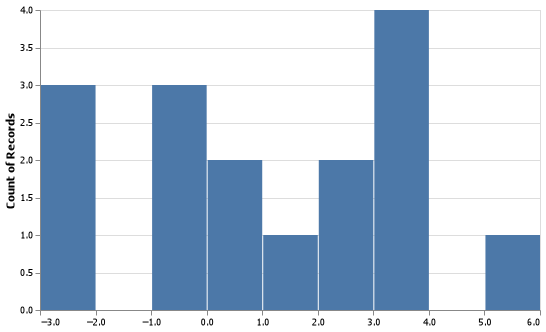

In [19]:
residuals = y_test_pred - y[test]
@vlplot(
    width=500,
    height=300,
    :bar, x={residuals, bin=true}, y="count()")

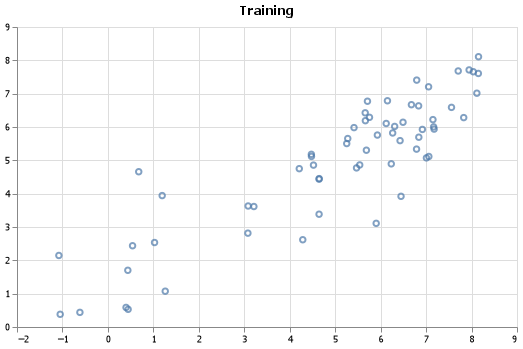

In [20]:
@vlplot(
    width=500,
    height=300,
    :point,
    x=y[train],
    y=y_train_pred,
    title="Training"
)

# Predict on new dataset

In [21]:
# Fit the machine using the complete training dataset
fit!(RandomForestModel)

┌ Info: Training Machine{Pipeline259,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{Standardizer,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403
┌ Info: Training Machine{RandomForestRegressor,…}.
└ @ MLJBase C:\Users\julio\.julia\packages\MLJBase\QXObv\src\machines.jl:403


Machine{Pipeline259,…} trained 2 times; caches data
  args: 
    1:	Source @357 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @251 ⏎ `AbstractVector{Continuous}`


In [22]:
# Import CSV to dataframe, select the same columns used for training
lichen = CSV.read("C:/Users/julio/Downloads/predicted_biomass_Nov2021.csv", DataFrame) |>
x -> select(x, :BASAL_AREA, :PL, :LON) |>
x -> rename(x, ["basalarea", "pl", "lon"]);

In [23]:
# Predict on a new dataset
biomass = exp.(predict(RandomForestModel, lichen))

213821-element Vector{Float64}:
  420.08888026680995
  330.3987020452265
  825.1394886795508
  623.8194848895803
 1329.8791801550403
  776.4454533334522
  776.4454533334522
  691.5844939761066
  978.5201395967265
  777.0616626493974
    ⋮
   67.73044457142227
  166.55268905606243
  169.76543608584518
   49.49864521272861
  182.92707083694015
  194.4472011465715
  182.92707083694015
   36.16012462262812
   50.64537204120837

In [30]:
# Combine new dataset with predictions
results = hcat(lichen, biomass)

,basalarea,pl,lon,x1
,Float64,Float64,Float64,Float64
1,29.1059,95.0,-125.514,420.089
2,33.2638,75.0,-125.46,330.399
3,32.757,95.0,-125.335,825.139
4,15.1756,80.0,-125.356,623.819
5,8.77539,100.0,-125.361,1329.88
6,37.5881,100.0,-125.331,776.445
7,37.5881,100.0,-125.326,776.445
8,35.5002,100.0,-125.405,691.584
9,37.5944,95.0,-125.373,978.52


In [32]:
# Export results to CSV
CSV.write("C:/Users/julio/Downloads/predicted_biomass_rf.csv", results)

"C:/Users/julio/Downloads/predicted_biomass_rf.csv"